In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import tensorflow as tf
from src import vrae, train, utils
import numpy as np

physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)
for gpu in physical_devices:
    tf.config.experimental.set_memory_growth(gpu, True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
batch_size = 1024
time_size = 256
over_len = 128

# Data Load

In [3]:
folder_path = "/works/Data/wellysis/mit-bih-long-term-ecg-database-1.0.0/"
data_col = utils.data_from_mit(folder_path)

print("Data Name List : {}".format(list(data_col.keys())))

data_sample = utils.make_dataformat_from_mit(data_col=data_col, name='14046', time_len=time_size, over_len=over_len)
print(data_sample.shape, data_sample.max(), data_sample.min())

# Return Tensor dataset
def tensorset(arr, shape, batch_size, drop_remainder=False):
    # type casting & reshaping
    data = arr.astype(np.float32)
    print("Before reshape : {}".format(data.shape))
    data = np.reshape(data, shape)
    print("After reshape : {} | data type : {}".format(data.shape, data.dtype))
    # make to tensor
    ds = tf.data.Dataset.from_tensor_slices(data)
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)
    return ds

train_set = tensorset(arr = data_sample, shape=(-1, time_size, 1), batch_size=batch_size)

Data Name List : ['14046', '14134', '14149', '14157', '14172', '14184', '15814']
(84599, 256, 1) 1.0 0.0
Before reshape : (84599, 256, 1)
After reshape : (84599, 256, 1) | data type : float32


# Model Load

In [4]:
from src import vrae_renew2

mod = vrae_renew2.VRAE(hidden_size=128, latent_length=30, output_depth=1, time_size=time_size)
mod.load_weights("/works/GitLab/jomjam/Python/AnomalyDetection/ECG/save/20210806_23_42_34_mit_2s_vrae_128enc_30z_128dec_bernoulliLikelihood_cycleKLD200basic_001kld_dataResample_bat1024_lr000005_v02/save")

# Get Latent Space

In [5]:
mu_col = np.zeros((1,30), dtype=np.float32)
std_col = np.zeros((1,30), dtype=np.float32)

for input_ in train_set:
    z_mu, z_std = mod.encoder(input_)
    
    mu_col = np.concatenate((mu_col, z_mu), axis=0)
    std_col = np.concatenate((std_col, z_std), axis=0)
    
mu_col = mu_col[1:]
std_col = std_col[1:]

print(mu_col.shape, std_col.shape)

(84599, 30) (84599, 30)


# Use Normal Distribution

### Cal KLD

In [6]:
kld_col = np.zeros((1,2), dtype=np.float32)
for mu_val, std_val in zip(mu_col, std_col):
    kld_with_normal_dist = np.sum(np.square(mu_val) + np.square(std_val) - np.log(1e-8 + np.square(std_val)) - 1)
    kld_col[-1,-1] = kld_with_normal_dist
    
    tmp = np.zeros((1,2), dtype=np.float32)
    tmp[0,0] = kld_with_normal_dist
    
    kld_col = np.concatenate((kld_col, tmp), axis=0)

kld_col[0,0] = kld_col[0,1]
kld_col[-1,-1] = kld_col[-1,0]
print(kld_col.shape)

(84600, 2)


In [7]:
# 평균으로 점수 구하기
kld_mean = np.mean(kld_col, axis=1)
print(kld_mean.shape)

(84600,)


In [8]:
kld_mean[np.argsort(kld_mean)]

extract_num = 10
low_sorted_idx = np.argsort(kld_mean)[:extract_num]
high_sorted_idx = np.argsort(kld_mean)[-extract_num:]

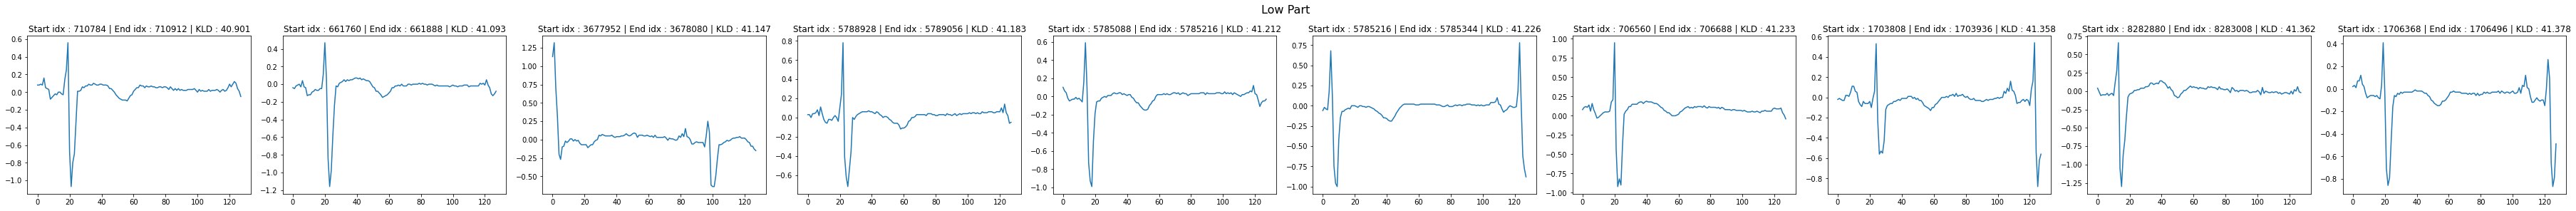

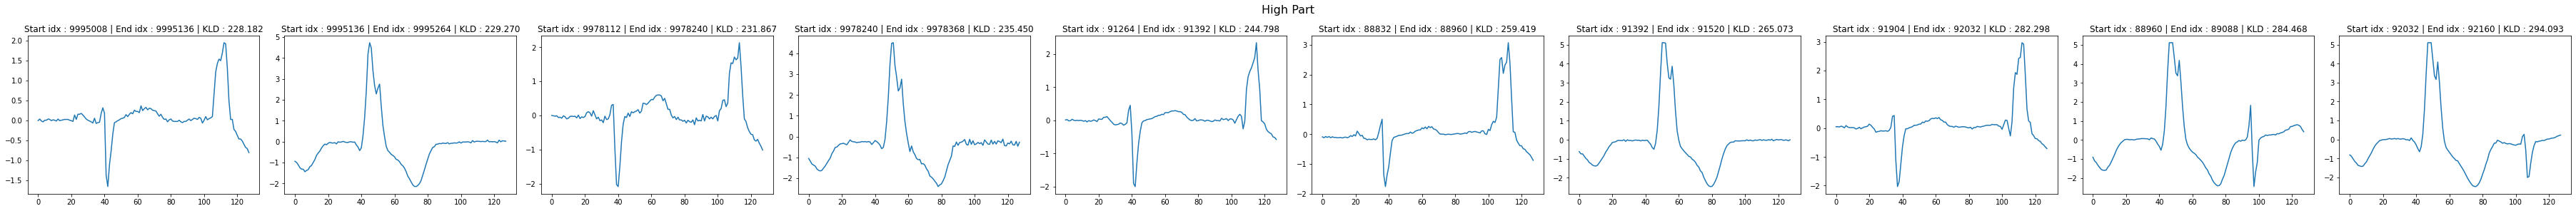

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

# 원본 Signal
origin_sig = data_col['14046'][0][:,0]

# Low Part
fig = plt.figure(figsize=(extract_num*5,4), constrained_layout=True)
axs = fig.subplots(1, extract_num)
for idx, ax in enumerate(axs):
    present_idx = low_sorted_idx[idx]
    start_idx = present_idx*128
    end_idx = (present_idx+1)*128
    sample_sig = origin_sig[start_idx:end_idx]
    ax.plot(np.arange(128), origin_sig[start_idx:end_idx])
    ax.set_title("Start idx : {} | End idx : {} | KLD : {:.3f}".format(start_idx, end_idx, kld_mean[present_idx]))
fig.suptitle('Low Part', fontsize=16)
plt.show()

# High Part
fig = plt.figure(figsize=(extract_num*5,4), constrained_layout=True)
axs = fig.subplots(1, extract_num)
for idx, ax in enumerate(axs):
    present_idx = high_sorted_idx[idx]
    start_idx = present_idx*128
    end_idx = (present_idx+1)*128
    sample_sig = origin_sig[start_idx:end_idx]
    ax.plot(np.arange(128), origin_sig[start_idx:end_idx])
    ax.set_title("Start idx : {} | End idx : {} | KLD : {:.3f}".format(start_idx, end_idx, kld_mean[present_idx]))
fig.suptitle('High Part', fontsize=16)
plt.show()

### Cal Euclidean distance

(84600, 2)
(84600,)


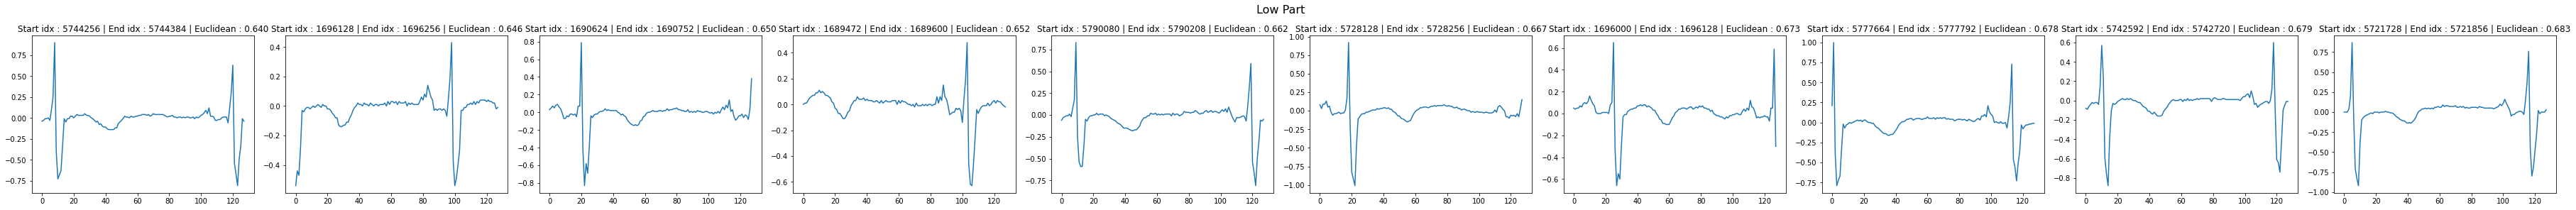

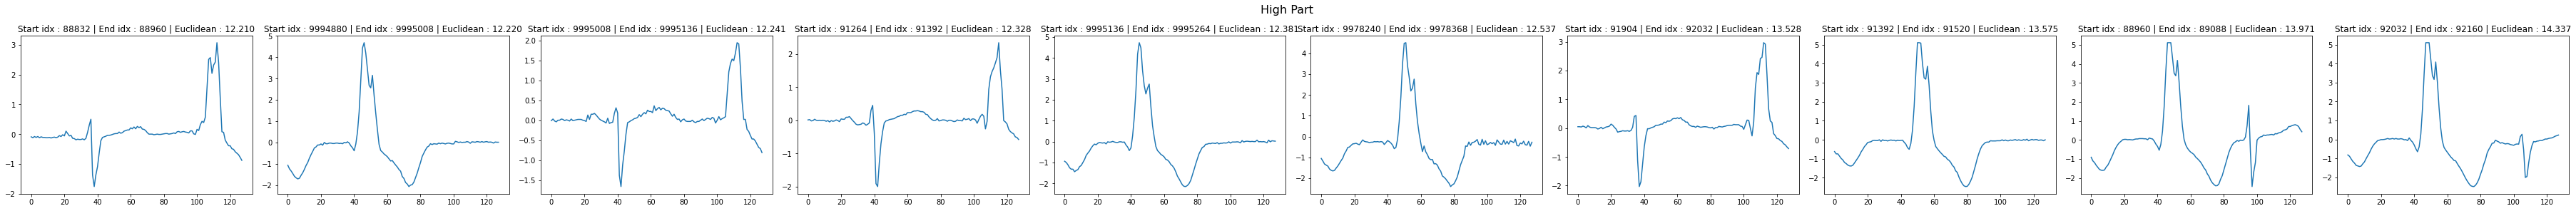

In [10]:
euclidean_col = np.zeros((1,2), dtype=np.float32)
for mu_val in mu_col:
    euclidean = np.sqrt(np.sum(np.square(mu_val)))
    euclidean_col[-1,-1] = euclidean
    
    tmp = np.zeros((1,2), dtype=np.float32)
    tmp[0,0] = euclidean
    
    euclidean_col = np.concatenate((euclidean_col, tmp), axis=0)

euclidean_col[0,0] = euclidean_col[0,1]
euclidean_col[-1,-1] = euclidean_col[-1,0]
print(euclidean_col.shape)

# 평균으로 점수 구하기
euclidean_mean = np.mean(euclidean_col, axis=1)
print(euclidean_mean.shape)

extract_num = 10
low_sorted_idx = np.argsort(euclidean_mean)[:extract_num]
high_sorted_idx = np.argsort(euclidean_mean)[-extract_num:]

# 원본 Signal
origin_sig = data_col['14046'][0][:,0]
    
# Low Part
fig = plt.figure(figsize=(extract_num*5,4), constrained_layout=True)
axs = fig.subplots(1, extract_num)
for idx, ax in enumerate(axs):
    present_idx = low_sorted_idx[idx]
    start_idx = present_idx*128
    end_idx = (present_idx+1)*128
    sample_sig = origin_sig[start_idx:end_idx]
    ax.plot(np.arange(128), origin_sig[start_idx:end_idx])
    ax.set_title("Start idx : {} | End idx : {} | Euclidean : {:.3f}".format(start_idx, end_idx, euclidean_mean[present_idx]))
fig.suptitle('Low Part', fontsize=16)
plt.show()

# High Part
fig = plt.figure(figsize=(extract_num*5,4), constrained_layout=True)
axs = fig.subplots(1, extract_num)
for idx, ax in enumerate(axs):
    present_idx = high_sorted_idx[idx]
    start_idx = present_idx*128
    end_idx = (present_idx+1)*128
    sample_sig = origin_sig[start_idx:end_idx]
    ax.plot(np.arange(128), origin_sig[start_idx:end_idx])
    ax.set_title("Start idx : {} | End idx : {} | Euclidean : {:.3f}".format(start_idx, end_idx, euclidean_mean[present_idx]))
fig.suptitle('High Part', fontsize=16)
plt.show()

# K-Means 방식 활용

In [11]:
from sklearn.cluster import KMeans

In [12]:
total_latent = np.concatenate((mu_col,std_col), axis=1)

def clustering_and_plot(cluster_num):
    Kmean = KMeans(n_clusters=cluster_num)
    Kmean.fit(total_latent)

    clustering_label = Kmean.predict(total_latent)

    for val in np.unique(clustering_label):
        print("Lable : {} | Num : {}".format(val, np.sum(clustering_label==val)))


    for_see = 10

    origin_sig = data_col['14046'][0][:,0]

    for lab in np.unique(clustering_label):
        fig = plt.figure(figsize=(for_see*5,4), constrained_layout=True)
        axs = fig.subplots(1, for_see)

        sample_idx = np.arange(len(clustering_label))[clustering_label==lab]
        random_idx = np.random.permutation(len(sample_idx))

        for idx, ax in enumerate(axs):
            present_idx = sample_idx[random_idx[idx]]

            start_idx = present_idx*128
            end_idx = (present_idx+1)*128

            ax.plot(np.arange(128), origin_sig[start_idx:end_idx])
            ax.set_title("Start Index : {} | End Index : {}".format(start_idx, end_idx))
        fig.suptitle('Cluster Number is {}'.format(lab), fontsize=16)
        plt.show()

# 2개 Cluster

Lable : 0 | Num : 47421
Lable : 1 | Num : 37178


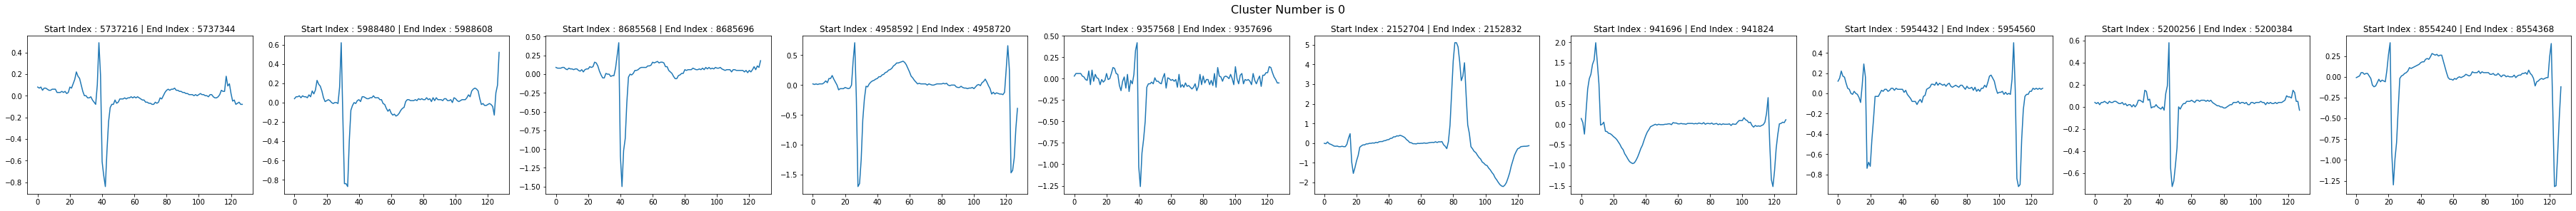

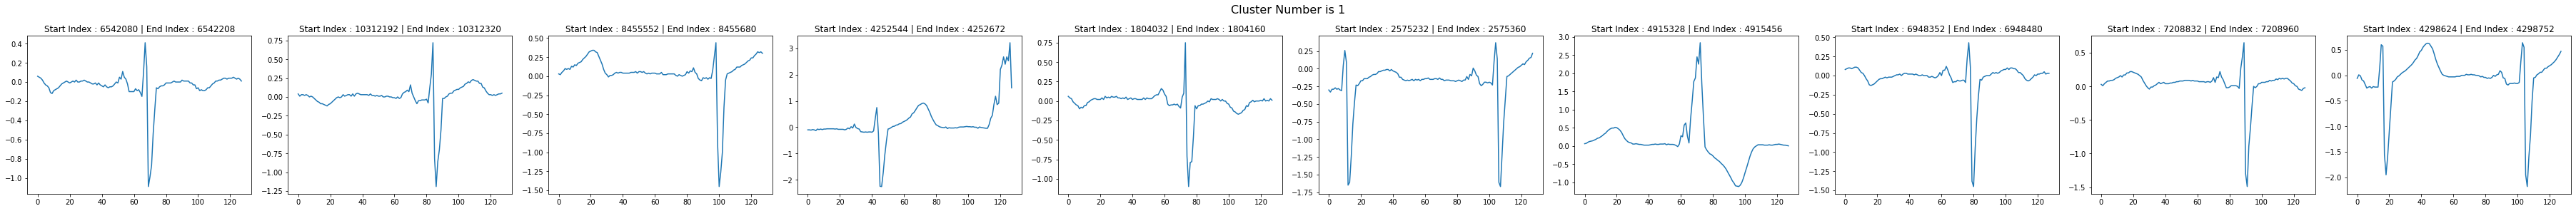

In [13]:
clustering_and_plot(2)

# 3개 Cluster

Lable : 0 | Num : 30274
Lable : 1 | Num : 50235
Lable : 2 | Num : 4090


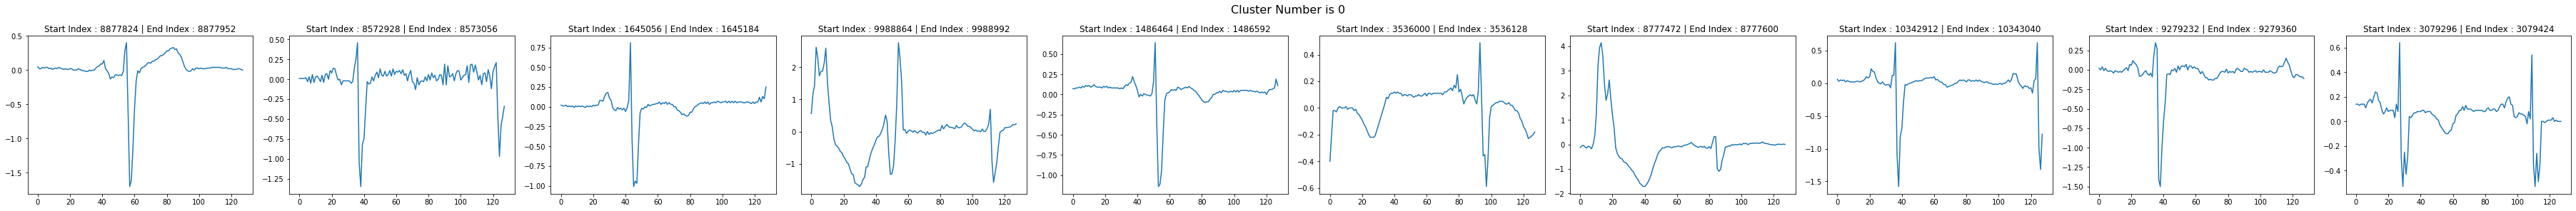

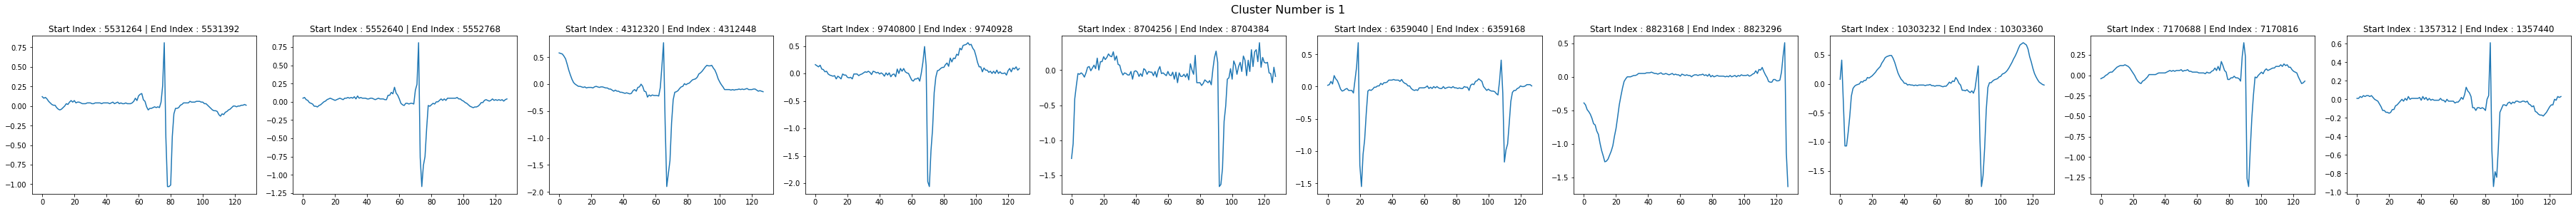

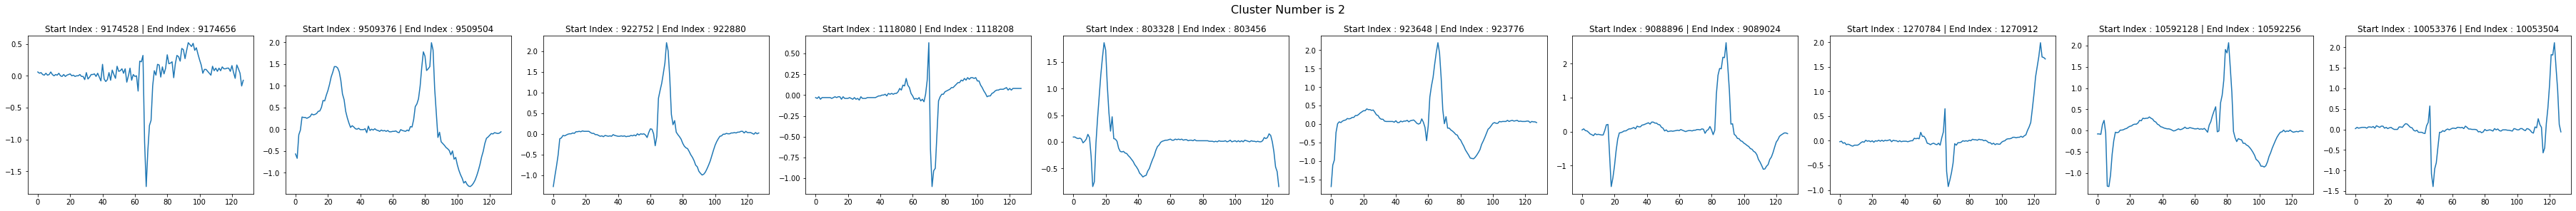

In [14]:
clustering_and_plot(3)

# 5개 Cluster

Lable : 0 | Num : 3151
Lable : 1 | Num : 22862
Lable : 2 | Num : 25636
Lable : 3 | Num : 3689
Lable : 4 | Num : 29261


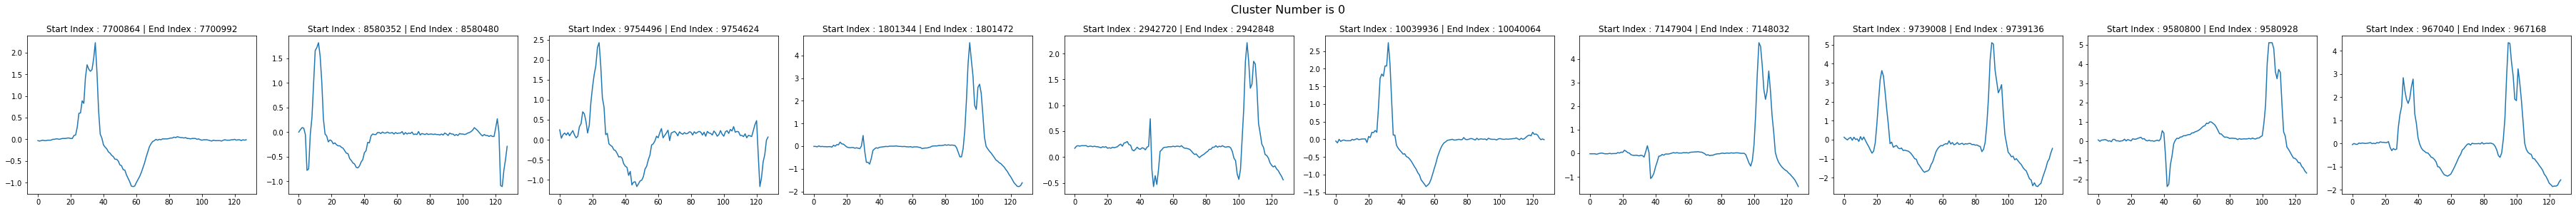

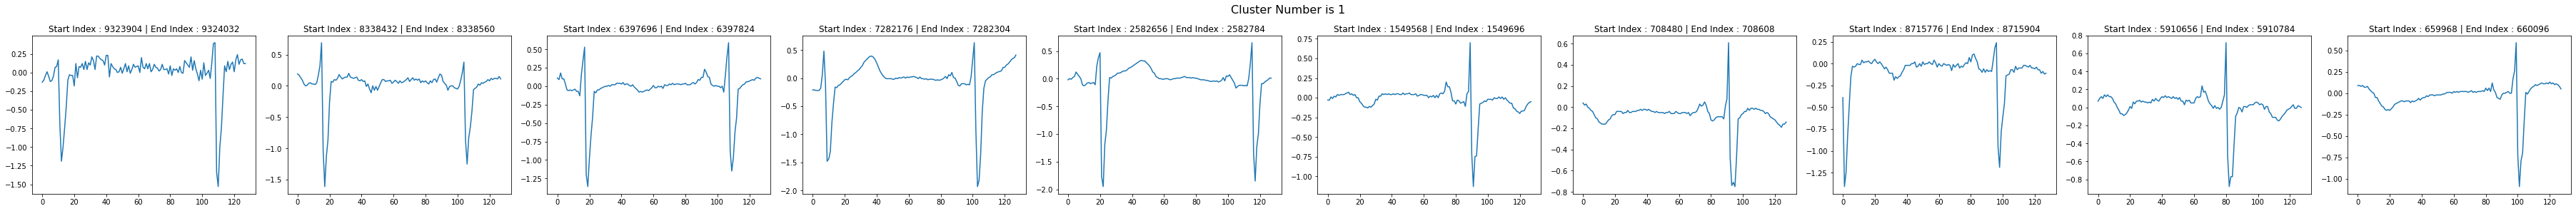

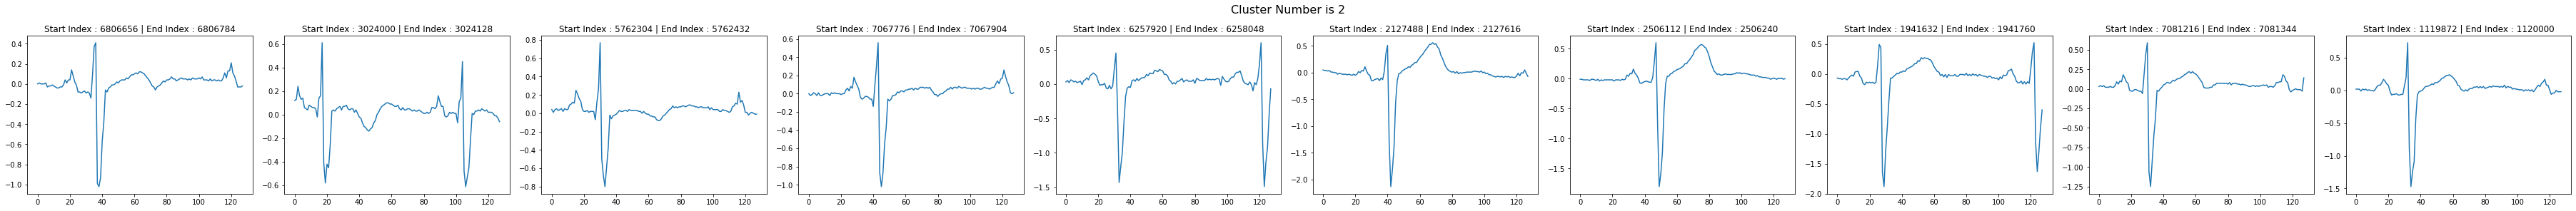

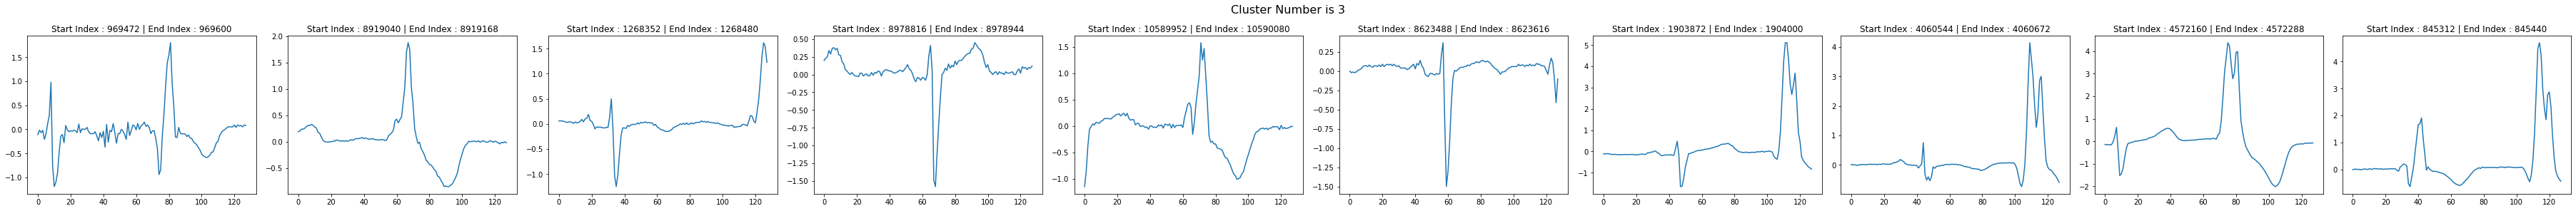

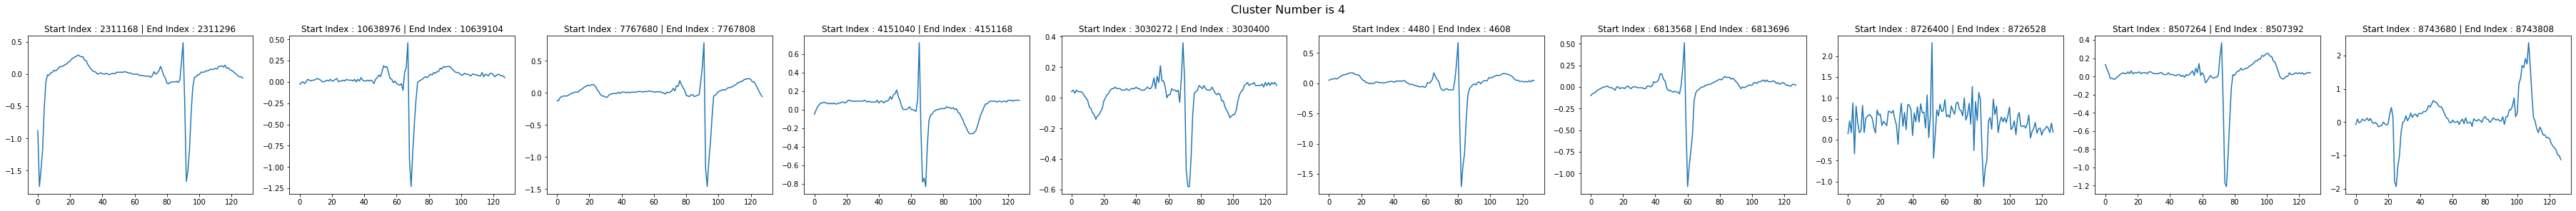

In [15]:
clustering_and_plot(5)

# 10개 Cluster

Lable : 0 | Num : 15369
Lable : 1 | Num : 1304
Lable : 2 | Num : 17261
Lable : 3 | Num : 16206
Lable : 4 | Num : 1947
Lable : 5 | Num : 1420
Lable : 6 | Num : 1506
Lable : 7 | Num : 14695
Lable : 8 | Num : 1179
Lable : 9 | Num : 13712


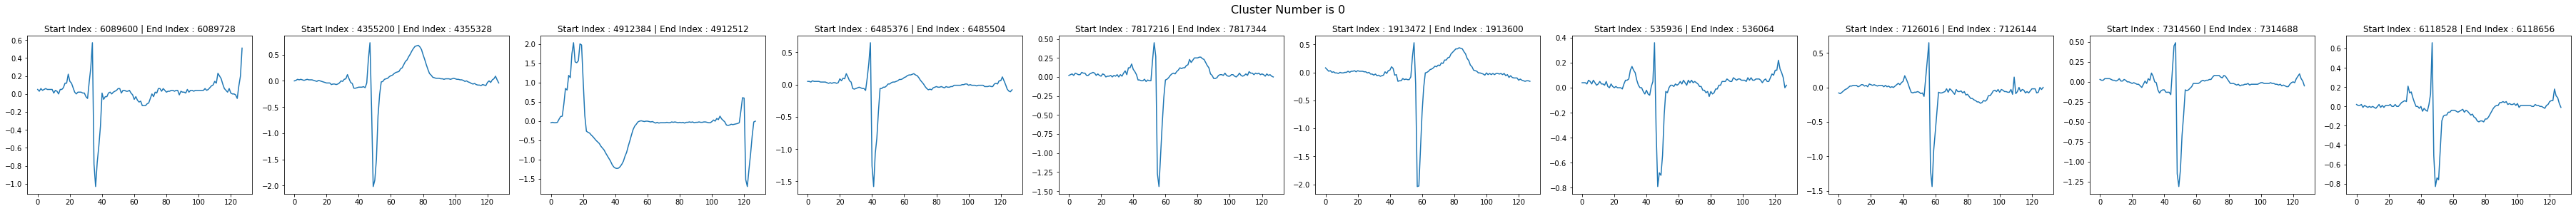

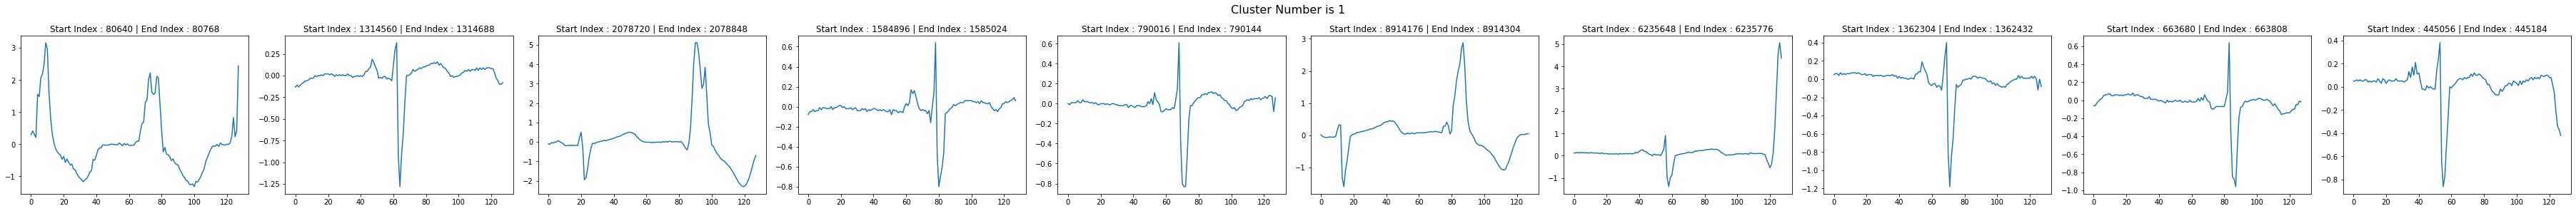

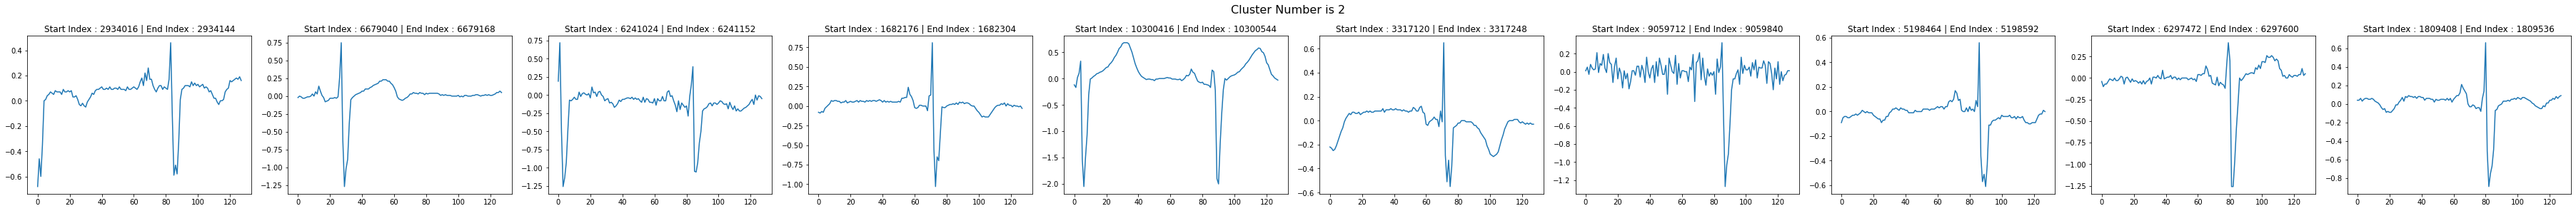

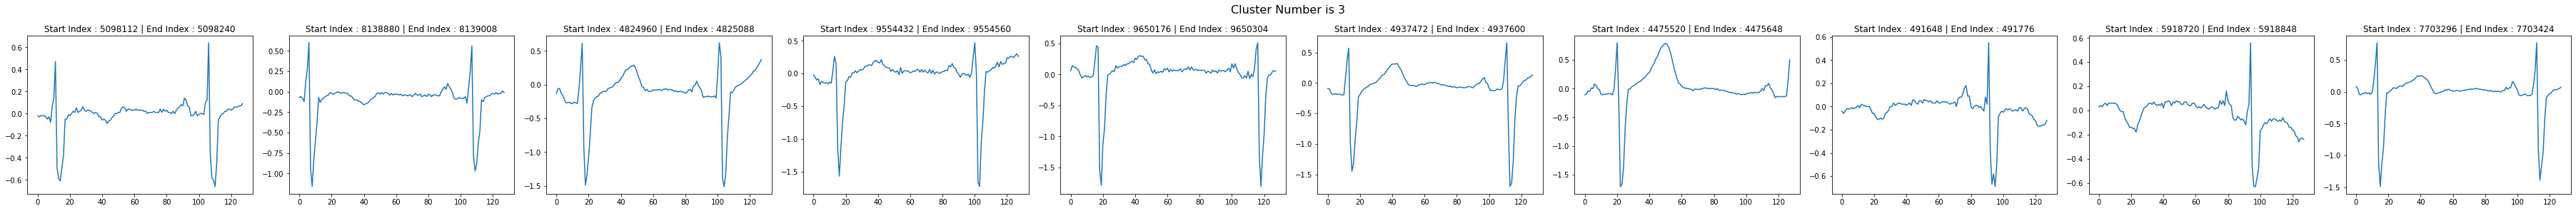

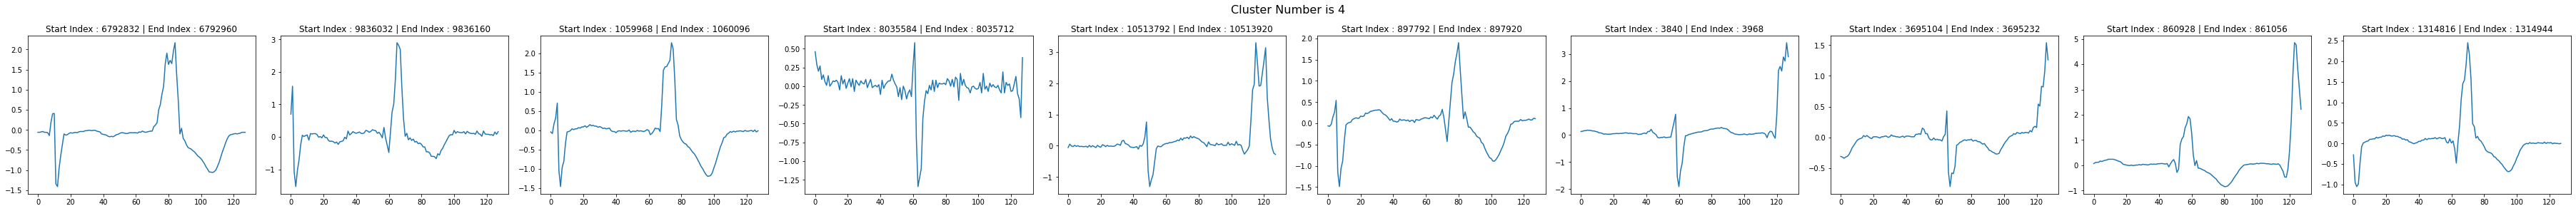

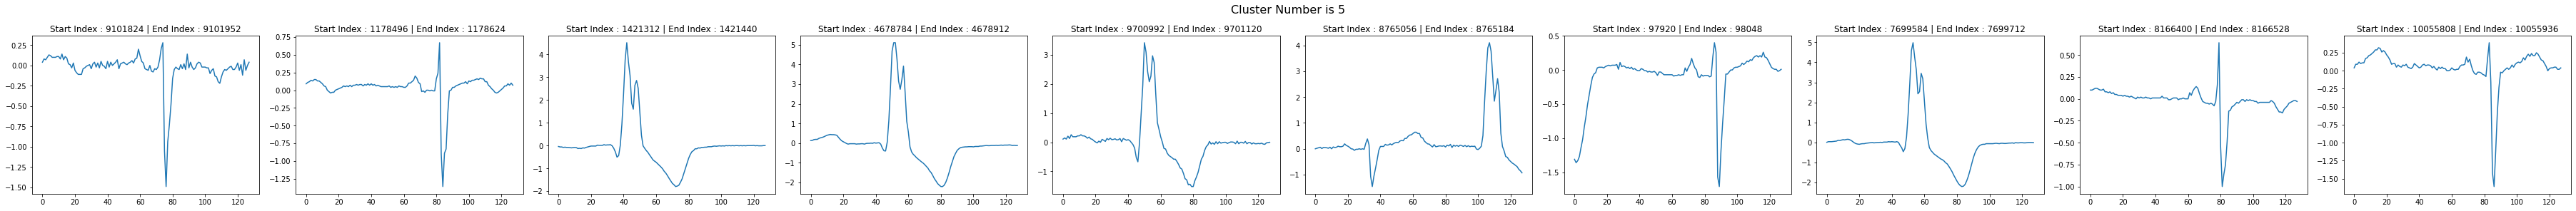

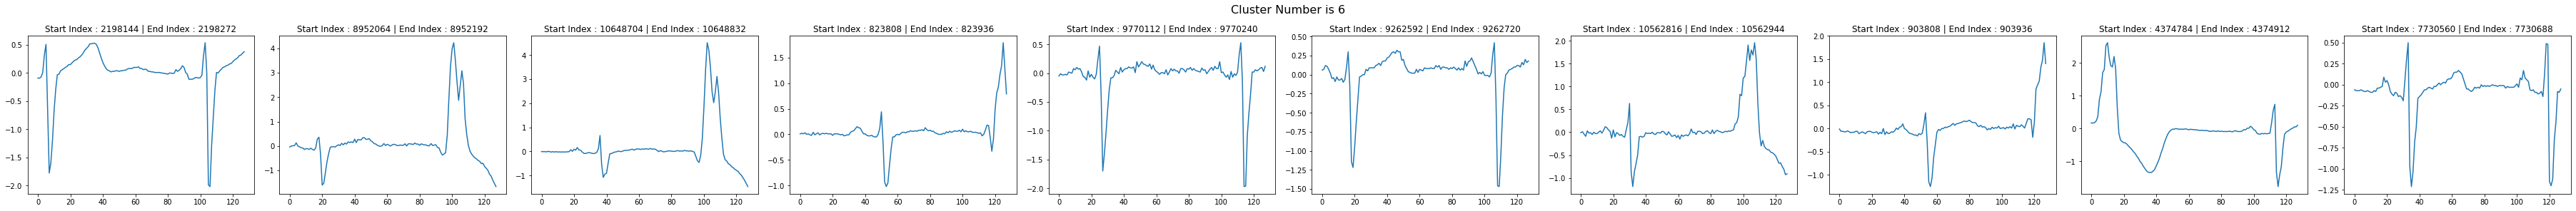

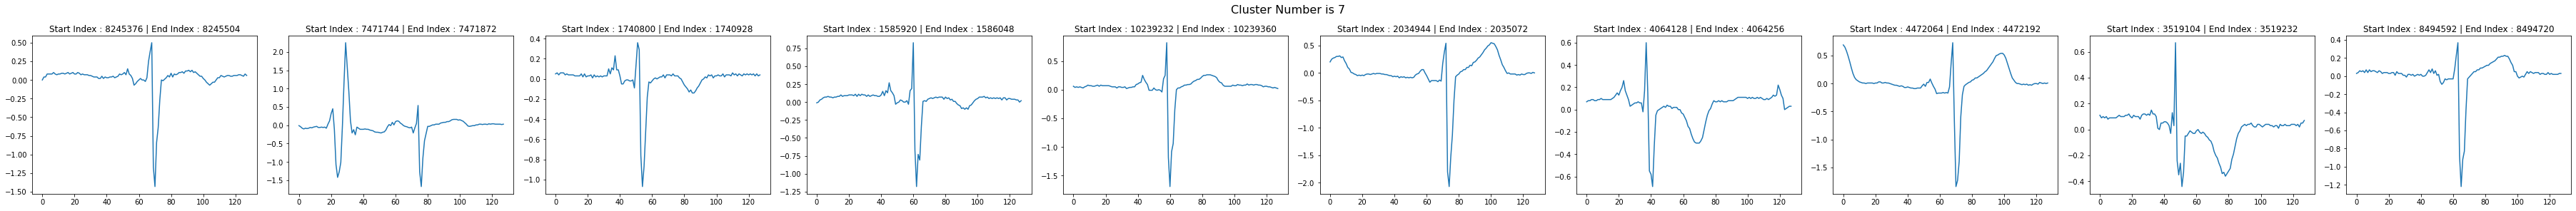

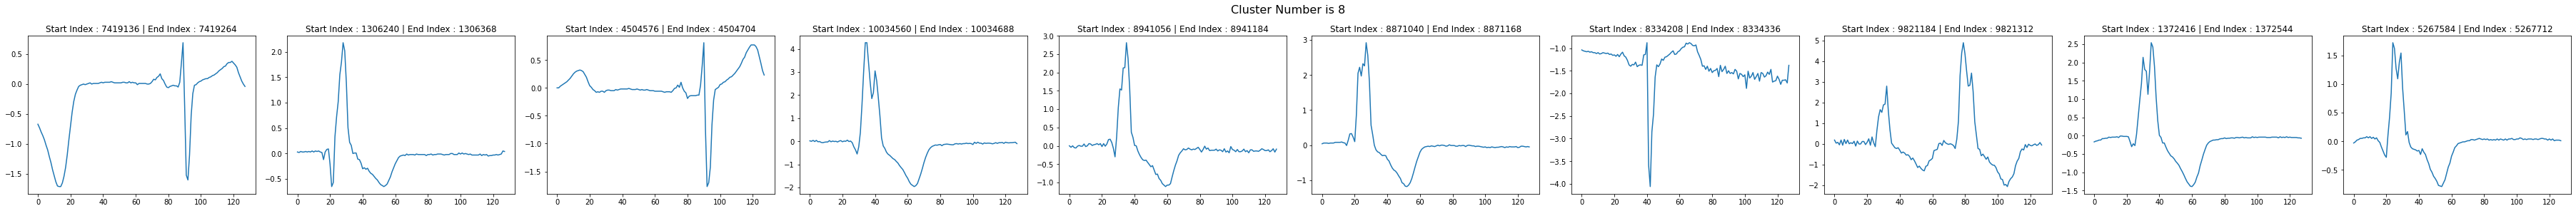

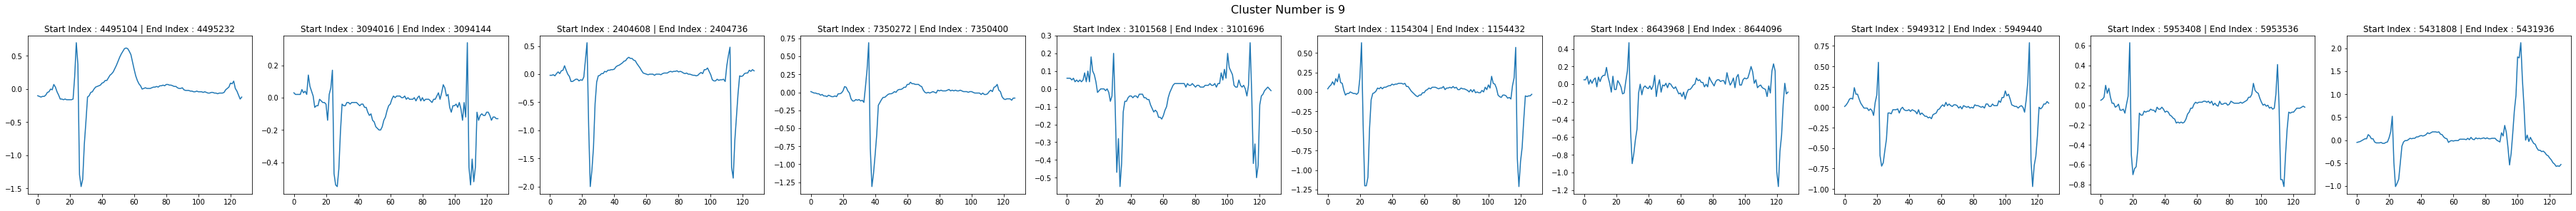

In [16]:
clustering_and_plot(10)